In [64]:
import fastf1
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import numpy as np
import sympy
from shapely.affinity import translate  
import math


In [65]:
#This is the API data that we pull
#session = fastf1.get_session(2023, 'Zanvoort', 'R')
session = fastf1.get_session(2023, 'Monza', 'R')

session.load(telemetry=True, laps=True, weather=False)
laps = session.laps
lap_55_1 = laps.pick_driver('1').pick_lap(10).get_telemetry()
f1_api_coords = list(zip(lap_55_1["Y"],lap_55_1["X"]))

core           INFO 	Loading data for Italian Grand Prix - Race [v3.3.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '44', '23', '4', '14', '77', '40', '81', '2', '24', '10', '18', '27', '20', '31', '22']
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed

In [66]:
lap_55_1.head(1)

,Date,SessionTime,DriverAhead,DistanceToDriverAhead,Time,RPM,Speed,nGear,Throttle,Brake,DRS,Source,Distance,RelativeDistance,Status,X,Y,Z
2,2023-09-03 13:36:20.737,0 days 01:35:19.692000,,46.36,0 days,11033,310,8,100,False,8,interpolation,0.158361,0.000027,OnTrack,-1380.42287,-759.758846,1871.240404


In [67]:
df = lap_55_1.drop(['Date', 'DriverAhead', 'DistanceToDriverAhead', 'Time',"Source","RelativeDistance"], axis=1)  


In [68]:
print(df.head(1).to_latex())

\begin{tabular}{lrrrrrlrrlrrr}
\toprule
{} &            SessionTime &    RPM &  Speed &  nGear &  Throttle &  Brake &  DRS &  Distance &   Status &           X &           Y &            Z \\
\midrule
2 & 0 days 01:35:19.692000 &  11033 &    310 &      8 &       100 &  False &    8 &  0.158361 &  OnTrack & -1380.42287 & -759.758846 &  1871.240404 \\
\bottomrule
\end{tabular}



C:\Users\KIRKE\AppData\Local\Temp\ipykernel_27852\3580812172.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.head(1).to_latex())


In [69]:
print(lap_55_1.head(1).to_latex())

\begin{tabular}{llrlrrrrrrlrlrrlrrr}
\toprule
{} &                    Date &            SessionTime & DriverAhead &  DistanceToDriverAhead &   Time &    RPM &  Speed &  nGear &  Throttle &  Brake &  DRS &         Source &  Distance &  RelativeDistance &   Status &           X &           Y &            Z \\
\midrule
2 & 2023-09-03 13:36:20.737 & 0 days 01:35:19.692000 &             &                  46.36 & 0 days &  11033 &    310 &      8 &       100 &  False &    8 &  interpolation &  0.158361 &          0.000027 &  OnTrack & -1380.42287 & -759.758846 &  1871.240404 \\
\bottomrule
\end{tabular}



C:\Users\KIRKE\AppData\Local\Temp\ipykernel_27852\1103907059.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(lap_55_1.head(1).to_latex())


In [70]:
#This plots the 

In [71]:
import geopandas as gpd
import folium

# Load the GeoDataFrame
monza_track = gpd.read_file("bacinger f1-circuits master circuits/it-1922.geojson") #This is monza
#monza_track = gpd.read_file("bacinger f1-circuits master circuits/nl-1948.geojson")

centroid = monza_track.geometry.centroid.iloc[0]

# Ensure the GeoDataFrame is in WGS84 (lat/lon)
#monza_track = monza_track.to_crs(epsg=4326)

# Convert to a projected CRS suitable for buffering (e.g., UTM)
# Note: Choose the correct UTM zone for your specific data. Here, we assume zone 32N.
# This is something we add manually 
monza_track_projected = monza_track.to_crs(epsg=32632)

# Process the geometry to add width by buffering (buffer distance in meters)
width_in_meters = 5  # Specify the width of the track. Adjust according to needs.
monza_track_buffered = monza_track_projected.copy(deep = True)
monza_track_buffered['geometry'] = monza_track_buffered.geometry.buffer(width_in_meters)

C:\Users\KIRKE\AppData\Local\Temp\ipykernel_27852\687770593.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = monza_track.geometry.centroid.iloc[0]


In [72]:
# Create a folium map centered at the centroid
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=15)

# Add the GeoDataFrame to the map
folium.GeoJson(monza_track_buffered).add_to(m)

# Display the map
#m.save("monza_track_map.html")
m  # This line is optional and just to display the map inline, if your

In [73]:
centroid_lon, centroid_lat = (centroid.x, centroid.y)  

    
# conversion factors - these are approximations, adjust as necessary  
# 1 degree of latitude is approximately 111 km, and 1 degree of longitude is approximately 111 km multiplied by the cosine of the latitude  
km_per_degree_lat = 1 / 110.574  
km_per_degree_lon = 1 / (111.320 * math.cos(math.radians(centroid_lat)))  



# your array of tuples  
yx_coordinates = f1_api_coords

# convert each tuple in the array  
lonlat_coordinates = []  
for y,x in yx_coordinates:  
    #Since each unit (x,y ) is in decimeters, we divide by 10000 since we are scaling pr kilomiters
    lon = centroid_lon + (x / 10000) * km_per_degree_lon  # assuming x, y are in meters  
    lat = centroid_lat + (y / 10000) * km_per_degree_lat  # assuming x, y are in meters  
    lonlat_coordinates.append((lon,lat)) 

In [74]:
relative_line = LineString(lonlat_coordinates)


In [75]:
# Your code  
gdf = gpd.GeoDataFrame(geometry=[relative_line], crs="EPSG:4326")    
new_projected = gdf.to_crs(epsg=32632)    
kat = folium.Map(location=[centroid.y, centroid.x], zoom_start=14, tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', attr="Esri")    

# Add GeoJson with red color  
folium.GeoJson(  
    new_projected,  
    style_function=lambda feature: {  
        'color': 'blue'  
    }  
).add_to(kat)  

In [76]:
kat

In [77]:
def coordinate_shift(original_centroid, f1_api_coords):
    """This translates the original relative coordinates into longitude and latitude
    original_centroid is the centroid computed from the downloaded track data
    """
    centroid_lon, centroid_lat = (original_centroid.x, original_centroid.y)  


      
    # conversion factors - these are approximations, adjust as necessary  
    # 1 degree of latitude is approximately 111 km, and 1 degree of longitude is approximately 111 km multiplied by the cosine of the latitude  
    km_per_degree_lat = 1 / 111  
    km_per_degree_lon = 1 / (111 * math.cos(math.radians(centroid_lat)))  
    
    # your array of tuples  
    xy_coordinates = f1_api_coords
    
    # convert each tuple in the array  
    lonlat_coordinates = []  
    for y,x in xy_coordinates:  
        lon = centroid_lon + (x / 10000) * km_per_degree_lon  # assuming x, y are in meters  
        lat = centroid_lat + (y / 10000) * km_per_degree_lat  # assuming x, y are in meters  
        lonlat_coordinates.append((lon,lat))  
    


    relative_line = LineString(lonlat_coordinates)
    return relative_line



def shift_centroid(relative_line,original_centroid):
    """This shift the centroid computed"""
    # Calculate the distance to translate in each direction  
    dx = original_centroid.x - relative_line.centroid.x  
    dy = original_centroid.y - relative_line.centroid.y  
    #print(dx, dy)
    #dx = -0.004080352801855369
    #dy = -0.0063870841787121435
    # Shift the LineString  
    shifted_line = translate(relative_line, xoff=dx, yoff=dy)  
    return shifted_line

In [78]:
scaled_down = coordinate_shift(centroid, f1_api_coords)
shifted_line = shift_centroid(scaled_down,centroid)

In [79]:
# Your code  
gdf = gpd.GeoDataFrame(geometry=[scaled_down], crs="EPSG:4326")    
new_projected = gdf.to_crs(epsg=32632)    
kat = folium.Map(location=[centroid.y, centroid.x], zoom_start=14, tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', attr="Esri")    
  
# Add GeoJson with red color  
folium.GeoJson(  
    monza_track_buffered,  
    style_function=lambda feature: {  
        'color': 'red'  
    }  
).add_to(kat)  

# Add GeoJson with red color  
folium.GeoJson(  
    new_projected,  
    style_function=lambda feature: {  
        'color': 'blue'  
    }  
).add_to(kat)  

folium.GeoJson(new_projected).add_to(kat)  
  
# Add a red marker  
folium.CircleMarker(  
    location=(centroid.y,centroid.x), # replace with the coordinates of the point  
    radius=5,  
    color='red',  
    fill=True,  
    fill_color='red'  
).add_to(kat)  

# Add a red marker  
folium.CircleMarker(  
    location=(scaled_down.centroid.y,scaled_down.centroid.x), # replace with the coordinates of the point  
    radius=5,  
    color='blue',  
    fill=True,  
    fill_color='blue'  
).add_to(kat)  
kat


In [80]:
# Update your GeoDataFrame  
gdf = gpd.GeoDataFrame(geometry=[shifted_line], crs="EPSG:4326")    
new_projected = gdf.to_crs(epsg=32632)  
  

kat = folium.Map(location=[centroid.y, centroid.x], zoom_start=14, tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', attr="Esri")  
folium.GeoJson(new_projected).add_to(kat)  
kat

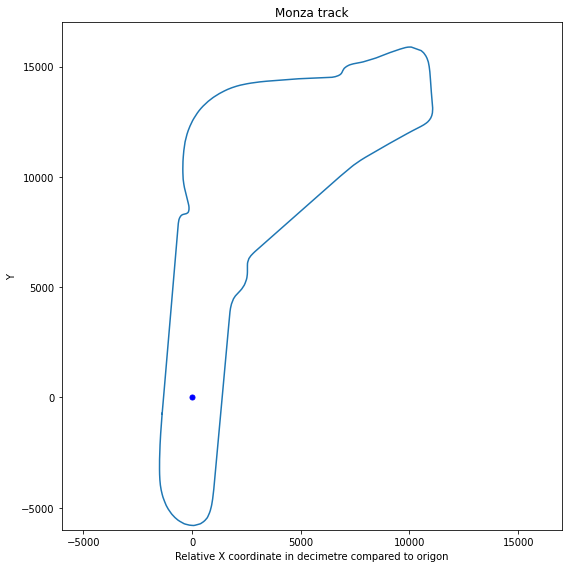

In [81]:
plt.figure(figsize=(8,8))  
  
# Get the current axes, creating one if necessary.  
ax = plt.gca()  
  
# Set the facecolor of the axes:  
ax.set_facecolor('white')  

plt.plot(lap_55_1['X'], lap_55_1['Y'], label='Driver 1')  
#plt.plot(lap_55_2['X'], lap_55_2['Y'], label='Driver 55')  
  
plt.plot(0, 0, marker='o', markersize=5, label='Point (0,0)', color='blue') # Add a blue dot at (0,0)  
  
plt.xlabel('Relative X coordinate in decimetre compared to origon')  
plt.ylabel('Y')  
plt.ylim(-6000,17000)  
plt.xlim(-6000,17000)  
  
plt.title('Monza track')  
  
plt.tight_layout()  # Adjust the layout  
#plt.savefig('monza_relative_coordinates.jpg')  # Save the figure  
plt.show()  

